<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/C%C3%A9sar/knn_svm_kmeans_16qam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.io import loadmat

%store -r

## Globales

In [2]:
PARAM_GRID_KNN = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
PARAM_GRID_SVM = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}    
    
def download_file(link):
    # Nombre del archivo
    file = link.split('/')[-1]
    
    # Descarga el archivo si no se ha hecho aún
    !if ! [[ -f "$file" ]]; then wget $link; fi;

    return file


# Función especial para leer todos los datos con la estructura estudiada
def read_data(folder_rx):
    data = {}

    # Leer la carpeta principal
    for folder in os.listdir(folder_rx):
        # Leer las subcarpetas
        if folder.endswith("spacing"):
            data[folder] = {}
            for file in os.listdir(f"{folder_rx}/{folder}"):
                if file.find("consY") != -1:
                    data_name = file.split("_")[2]
                    if data[folder].get(data_name) == None:
                        data[folder][data_name] = {}
                    mat_file_data = loadmat(f"{folder_rx}/{folder}/{file}")
                    data[folder][data_name] = mat_file_data
    return data

# Función para demodular de manera tradicional, usando KNN y SVM
def supervised_demod(X_rx, X_tx, train_size):
    ber = {}
    
    for i, snr in enumerate(X_rx):
        # Extraer información
        X_ch_norm = X_rx[snr].get("const_Y").flatten()
        X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm

        # Arreglos para el BER de cada algoritmo
        trad_ber = np.empty(4)
        knn_ber = np.empty(4)
        svm_ber = np.empty(4)

        for ph in range(4):
            # Rotar constelación
            rotated_X = X_ch*np.exp(ph*1j*np.pi/2)
            
            # Sincronizar de las señales
            synced_X_tx = sofa.sync_signals(X_tx, rotated_X)
            
            # Demodular señal transmitida
            y = sofa.demodulate(synced_X_tx, sofa.MOD_DICT)

            # Mejores parámetros para los algoritmos
            # best_params_knn = sofa.find_best_params(KNeighborsClassifier, PARAM_GRID_KNN, rotated_X, y)
            # best_params_svm = sofa.find_best_params(SVC, PARAM_GRID_SVM, rotated_X, y)
            
            # k = best_params_knn["n_neighbors"] 
            # C = best_params_svm["C"]
            # gamma = best_params_svm["gamma"]
            
            k = 5
            C = 10
            gamma = 0.01
            
            # Demodulación
            trad = sofa.demodulate(rotated_X, sofa.MOD_DICT)
            knn = sofa.demodulate_knn(rotated_X, y, k = k,
                                      train_size = train_size)
            svm = sofa.demodulate_svm(rotated_X, y, C = C, gamma = gamma,
                                      train_size = train_size)
            
            # BER de la demodulación con respecto a la transmitida desplazada
            trad_ber[ph] = sofa.bit_error_rate(trad, y)[0]
            knn_ber[ph] = sofa.bit_error_rate(knn, y)[0]
            svm_ber[ph] = sofa.bit_error_rate(svm, y)[0]

        ber[snr] = {"trad": np.amin(trad_ber),
                    "knn": np.amin(knn_ber),
                    "svm": np.amin(svm_ber)}
        
        # Mensaje para saber que se progresa
        print(f"SNR {snr[5:]} terminado.")
    return ber

def curve_fit(f, x, y):
    popt, pcov = sp.optimize.curve_fit(f, x, y)
    return popt

def spacing_ber_eval(ber, spacing):
    print(f"Evaluación de algoritmos supervisados para espaciamiento de {spacing} GHz")
    
    # Lista de strings con los SNR
    SNR = [snr[5:-2] for snr in list(data[f"{spacing}GHz_spacing"].keys())]

    SNR.sort()
    
    get_ber = lambda algorithm: [np.log10(ber.get(f"consY{snr_i}dB").get(algorithm)) for snr_i in SNR]
    tBER = get_ber("trad")
    kBER = get_ber("knn")
    sBER = get_ber("svm")

    # Función para usar en la gráfica
    f = lambda x, a, b, c: a * x**2 + b * x + c
    
    # Arreglo con los SNR como flotantes
    dSNR = np.array(SNR, dtype = np.float64)
    xSNR = np.linspace(float(SNR[0]), float(SNR[-1]), 1000)

    plt.figure(figsize = (10, 6))
    # Tradicional: Brown
    # KNN: Green
    # SVM: Orange
    plt.scatter(dSNR, tBER, marker="^", c="brown", label="Tradicional")
    plt.plot(xSNR, f(xSNR, *curve_fit(f, dSNR, tBER)),
             c="brown", ls="dashed", label="Tradicional (fit)");
    plt.scatter(dSNR, kBER, marker = "x", c="green", label = "KNN")
    plt.plot(xSNR, f(xSNR, *curve_fit(f, dSNR, kBER)),
             c="green", ls="dashed", label="KNN (fit)");
    plt.scatter(dSNR, sBER, marker = "o", c="orange", label = "SVM")
    plt.plot(xSNR, f(xSNR, *curve_fit(f, dSNR, sBER)),
             c="orange", ls="dashed", label="SVM (fit)");
    
    plt.title(f"{spacing} GHz spacing")
    plt.xlabel("OSNR (dB)")
    plt.ylabel("BER [10^]")
    plt.legend(loc = "upper right")
    plt.grid()
    plt.show()

## Librería de funciones

In [3]:
import sofa

## Datos experimentales

In [4]:
file_tx = "Datos/2x16QAM_16GBd.mat"
folder_rx = "Datos/"

# Datos transmitidos
X_tx_norm = loadmat(file_tx)
X_tx_norm = X_tx_norm.get("Constellation").flatten()[0][0].flatten()
X_tx = sofa.mod_norm(X_tx_norm, 10)*X_tx_norm

# Leer los datos recibidos
data = read_data(folder_rx)

In [5]:
import datetime
print(f"Inicio: {datetime.datetime.now()}")

    
def calc_ber_once(spacing: str):
    if f"ber{spacing.replace('.', '_')}" not in globals():
        return supervised_demod(data[f"{spacing}GHz_spacing"], X_tx,
                                train_size = 0.4)
    return eval(f"ber{spacing.replace('.', '_')}")

Inicio: 2023-03-17 16:00:29.378404


## Espaciamiento de 18 GHz

Stored 'ber18' (dict)
Evaluación de algoritmos supervisados para espaciamiento de 18 GHz


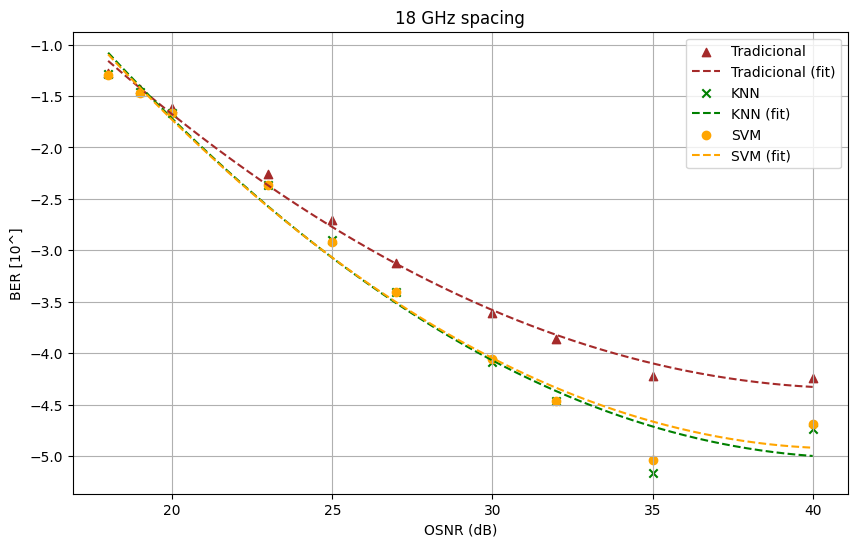

In [6]:
spacing = "18"

ber18 = calc_ber_once(spacing)

%store ber18

spacing_ber_eval(ber18, spacing)

## Espaciamiento de 17.6 GHz

Stored 'ber17_6' (dict)
Evaluación de algoritmos supervisados para espaciamiento de 17.6 GHz


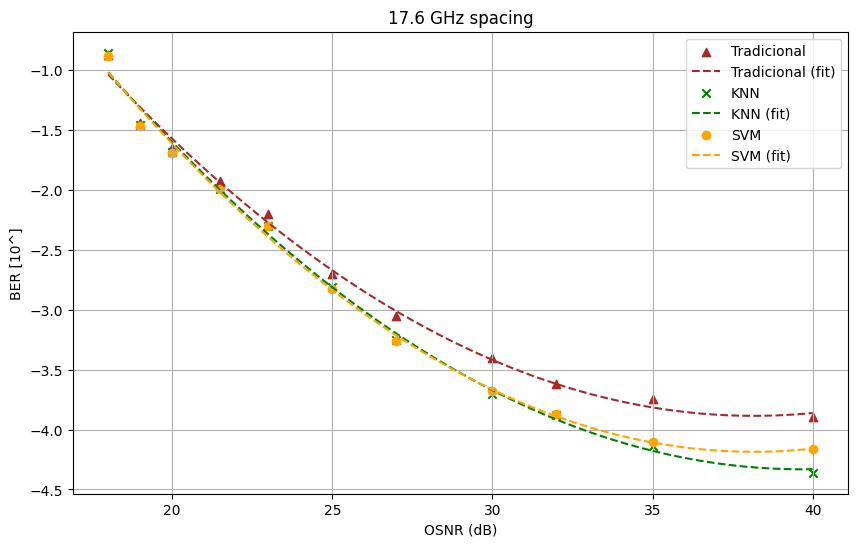

In [7]:
spacing = "17.6"

ber17_6 = calc_ber_once(spacing)

%store ber17_6

spacing_ber_eval(ber17_6, spacing)

## Espaciamiento de 17 GHz

Stored 'ber17' (dict)
Evaluación de algoritmos supervisados para espaciamiento de 17 GHz


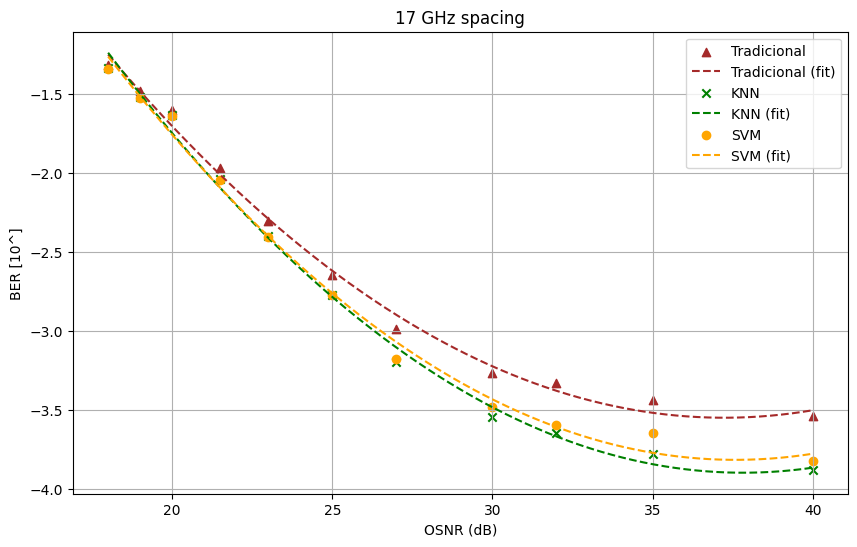

In [8]:
spacing = "17"

ber17 = calc_ber_once(spacing)

%store ber17

spacing_ber_eval(ber17, spacing)

## Espaciamiento de 16.5 GHz

Stored 'ber16_5' (dict)
Evaluación de algoritmos supervisados para espaciamiento de 16.5 GHz


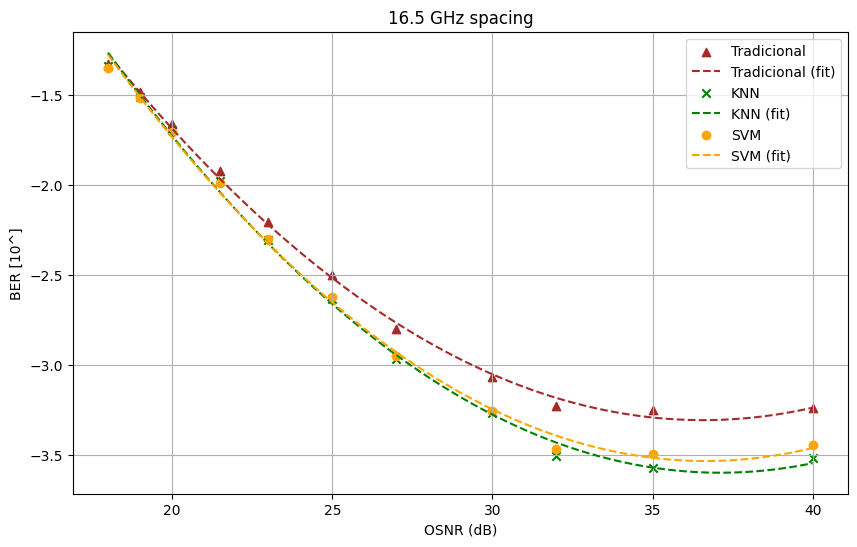

In [9]:
spacing = "16.5"

ber16_5 = calc_ber_once(spacing)

%store ber16_5

spacing_ber_eval(ber16_5, spacing)

## Espaciamiento de 16 GHz

Stored 'ber16' (dict)
Evaluación de algoritmos supervisados para espaciamiento de 16 GHz


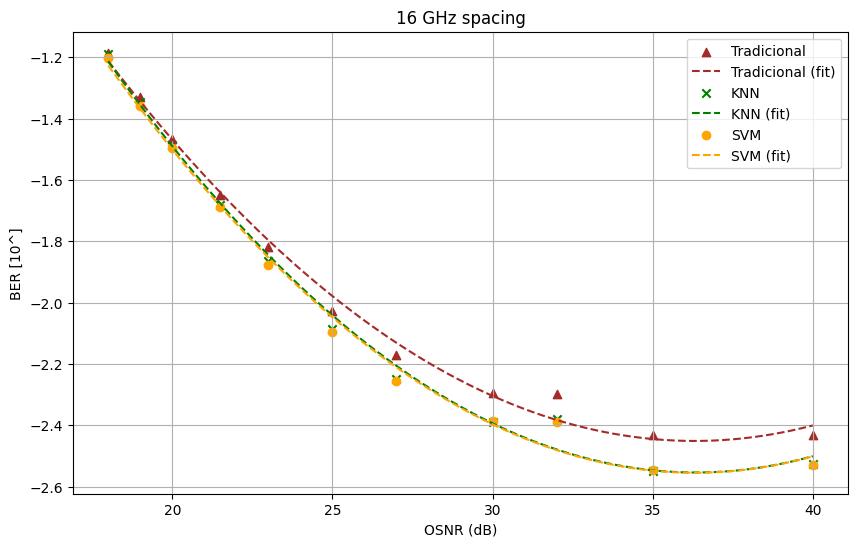

In [10]:
spacing = "16"

ber16 = calc_ber_once(spacing)

%store ber16

spacing_ber_eval(ber16, spacing)

## Espaciamiento de 15.5 GHz

Stored 'ber15_5' (dict)
Evaluación de algoritmos supervisados para espaciamiento de 15.5 GHz


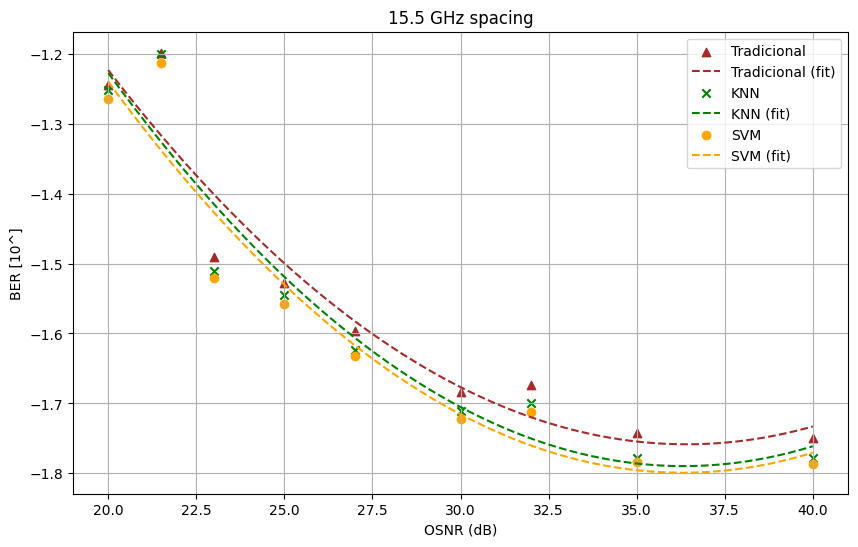

In [11]:
spacing = "15.5"

ber15_5 = calc_ber_once(spacing)

%store ber15_5

spacing_ber_eval(ber15_5, spacing)

## Espaciamiento de 15 GHz

Stored 'ber15' (dict)
Evaluación de algoritmos supervisados para espaciamiento de 15 GHz


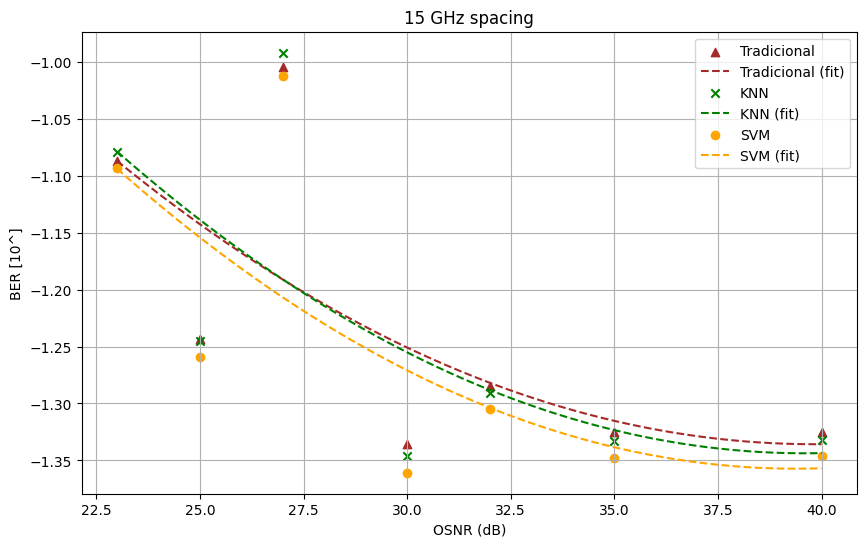

In [12]:
spacing = "15"

ber15 = calc_ber_once(spacing)

%store ber15

spacing_ber_eval(ber15, spacing)

In [13]:
print(f"Final: {datetime.datetime.now()}")

Final: 2023-03-17 16:00:38.194213
